In [12]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE
from jaxtronomy.GaussianRandomField.GRF_fitting import fit_image_function,GRF_Loss_complete

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

# Lensing setup (unknown to us)

In [13]:
#GRF true parameters
GRF_LogAmp=-7.
GRF_beta=2.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [14]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [15]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [16]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [17]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=1000
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': np.inf}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

## Perturbed and unperturbed images

In [18]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)
unperturbed_data_image=simulate_smooth_image(kwargs_data,smooth_lens_image)

(-0.5, 99.5, -0.5, 99.5)

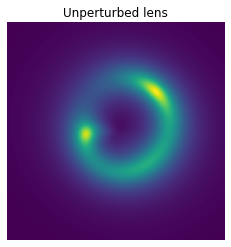

In [19]:
plt.imshow(unperturbed_data_image, origin='lower')
plt.title('Unperturbed lens')
plt.axis('off')

(-0.5, 99.5, -0.5, 99.5)

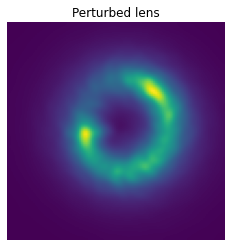

In [20]:
plt.imshow(data_image, origin='lower')
plt.title('Perturbed lens')
plt.axis('off')

## Gaussian random field perturbation examples

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_36336/3570820121.py:5: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax[0].imshow(im,origin='lower',vmin=im.min(),vmax=im.max(),cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_36336/3570820121.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax[1].imshow(im1,origin='lower',vmin=im.min(),vmax=im.max(),cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))


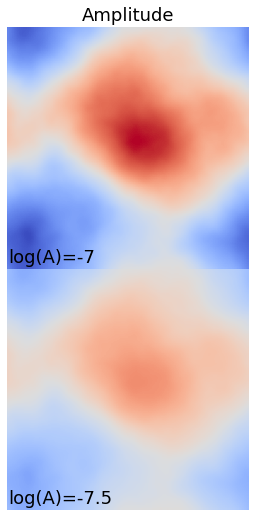

In [10]:
fig,ax=plt.subplots(2,1,figsize=(20,7))

im=get_jaxified_GRF([-7.,5.],GRF_seed,npix,pix_scl)

ax[0].imshow(im,origin='lower',vmin=im.min(),vmax=im.max(),cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].text(0,2,'log(A)=-7',fontsize=FS)

im1=get_jaxified_GRF([-7.5,5.],GRF_seed,npix,pix_scl)
ax[1].imshow(im1,origin='lower',vmin=im.min(),vmax=im.max(),cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].text(0,2,'log(A)=-7.5',fontsize=FS)

for i in range(2):
    ax[i].axis('off')
    
fig.tight_layout(h_pad=-0.01)
fig.suptitle('Amplitude',y=1.02,fontsize=FS)
plt.show()

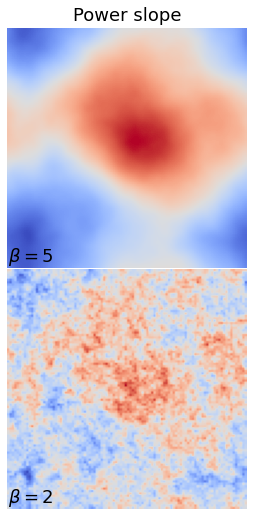

In [11]:
fig,ax=plt.subplots(2,1,figsize=(20,7))

im=get_jaxified_GRF([-7.,5.],GRF_seed,npix,pix_scl)

ax[0].imshow(im,origin='lower',cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].text(0,2,r'$\beta=5$',fontsize=FS)

im1=get_jaxified_GRF([-7.,2.],GRF_seed,npix,pix_scl)
ax[1].imshow(im1,origin='lower',cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
ax[1].text(0,2,r'$\beta=2$',fontsize=FS)

for i in range(2):
    ax[i].axis('off')
    
fig.tight_layout(h_pad=-0.01)
fig.suptitle('Power slope',y=1.02,fontsize=FS)
plt.show()

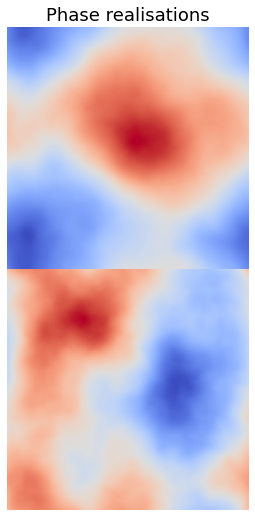

In [12]:
fig,ax=plt.subplots(2,1,figsize=(20,7))

im=get_jaxified_GRF([-7.,5.],1,npix,pix_scl)

ax[0].imshow(im,origin='lower',cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
#ax[0].text(0,2,r'$\beta=2$',fontsize=FS)

im1=get_jaxified_GRF([-7.,5.],2,npix,pix_scl)
ax[1].imshow(im1,origin='lower',cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0))
#ax[1].text(0,2,r'$\beta=7$',fontsize=FS)

for i in range(2):
    ax[i].axis('off')
    
fig.tight_layout(h_pad=-0.01)
fig.suptitle('Phase realisations',y=1.02,fontsize=FS)
plt.show()

$PS=A \cdot k^{-\beta}$

# Data preparation

## Fit data to know lens-source kwargs

In [21]:
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


def fit_data(data,lens_image,parameters,method='BFGS'):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method=method, restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

  return kwargs_final

#First guess from priors
kwargs_intermediate={'kwargs_lens': [{'theta_E': 1.5,'e1': 1e-3,'e2': 1e-3,'center_x': 1e-3,'center_y': 1e-3},{'gamma1': 1e-3, 'gamma2': 1e-3, 'ra_0': 0.0, 'dec_0': 0.0}],
                     'kwargs_source': [{'amp': 5.0,'R_sersic': 2.5,'n_sersic': 2.,'center_x': 0.,'center_y': 0.,'e1': 1e-3,'e2': 1e-3}],
                     'kwargs_lens_light': [{}]}

parameters=get_parameters(kwargs_intermediate,lens_mass_model_list,source_light_model_list)

### Example of fit residuals variation

In [14]:
#Get guess of true kwargs

example_GRF_realisation=GRF_realisation=get_jaxified_GRF([-8.5,7.],2,npix,pix_scl)
example_perturbed_image=simulate_perturbed_image(example_GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)

kwargs_guess1=fit_data(example_perturbed_image,smooth_lens_image,parameters,method='Newton-CG')
args_guess1=parameters.kwargs2args(kwargs_guess1)

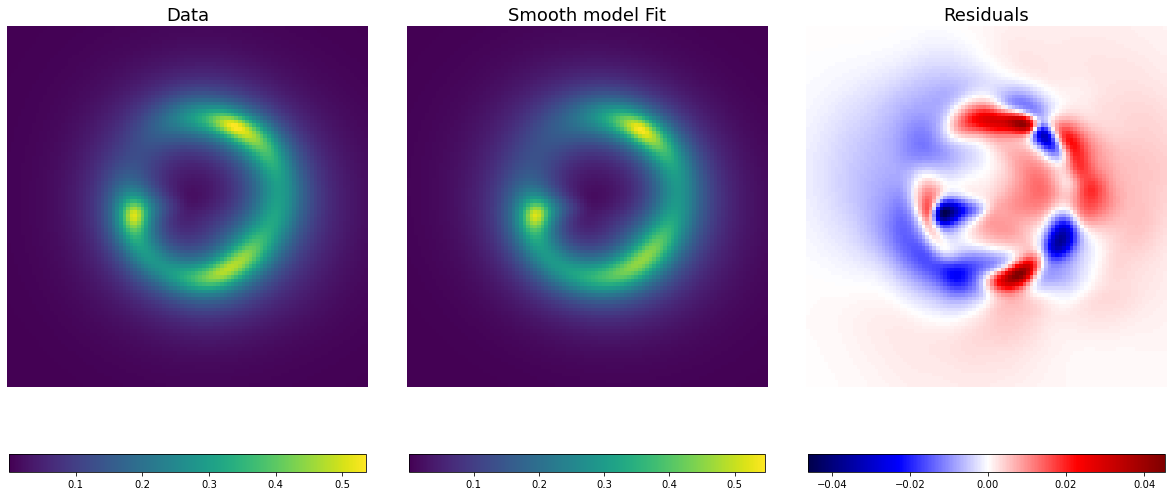

In [15]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(20,7))

im_arr=[]

im=ax[0].imshow(example_perturbed_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data',fontsize=FS)

fit_image=smooth_lens_image.model(**kwargs_guess1)
im=ax[1].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Smooth model Fit',fontsize=FS)

example_residuals=example_perturbed_image-fit_image
im=ax[2].imshow(example_residuals,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals',fontsize=FS)

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal',fraction=0.04)
    
fig.tight_layout(w_pad=-20)
plt.show()

### Studied image fit

In [22]:
kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
args_guess=parameters.kwargs2args(kwargs_guess)

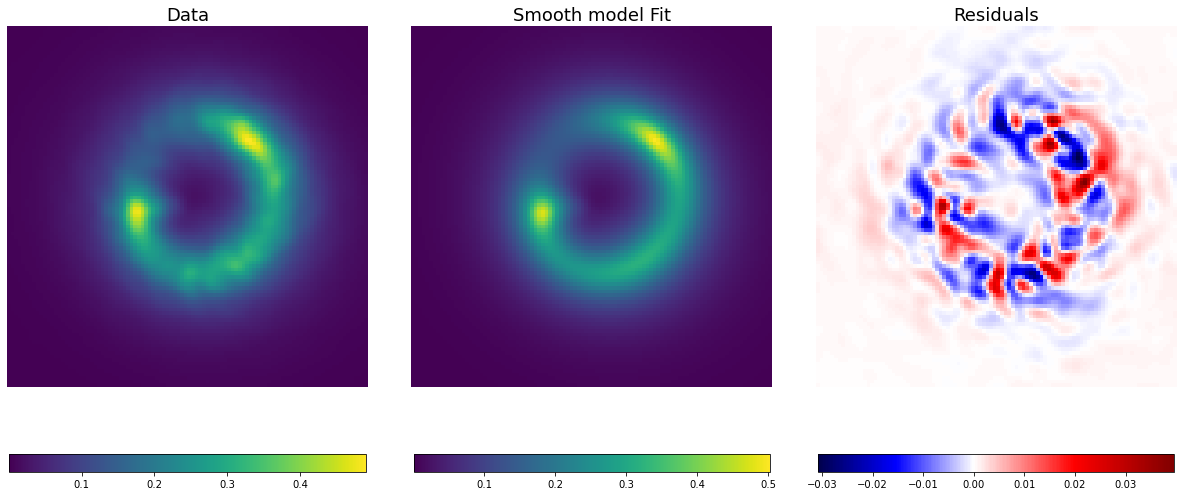

In [23]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(20,7))

im_arr=[]

im=ax[0].imshow(data_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data',fontsize=FS)

fit_image=smooth_lens_image.model(**kwargs_guess)
im=ax[1].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Smooth model Fit',fontsize=FS)

im=ax[2].imshow(data_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals',fontsize=FS)

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal',fraction=0.04)
    
fig.tight_layout(w_pad=-20)
plt.show()

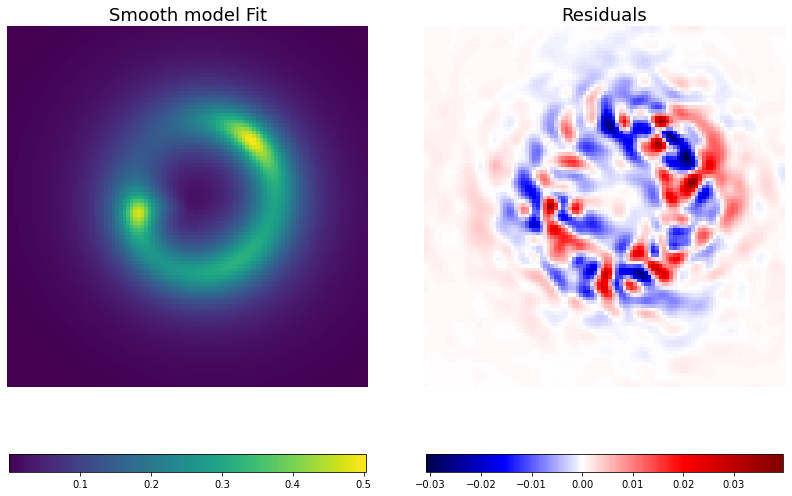

In [25]:
fig,ax=plt.subplots(1,2,figsize=(20,7))

im_arr=[]


fit_image=smooth_lens_image.model(**kwargs_guess)
im=ax[0].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Smooth model Fit',fontsize=FS)

im=ax[1].imshow(data_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[1].set_title('Residuals',fontsize=FS)

for i in range(2):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal',fraction=0.04)
    
fig.tight_layout(w_pad=-40)
plt.show()

In [ ]:
dif_phase_GRF_realisation=GRF_realisation=get_jaxified_GRF([-7.5,4.],2,npix,pix_scl)
dif_phase_perturbed_image=simulate_perturbed_image(dif_phase_GRF_realisation,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
dif_phase_kwargs=fit_data(dif_phase_perturbed_image,smooth_lens_image,parameters,method='Newton-CG')

Data potential: $\psi_0+\delta \psi(A,\beta,\phi)$  
Fit data potential: $\psi_1$

Simulated potential: $\psi_1+\delta \psi(\widetilde{A},\widetilde{\beta},\widetilde{\phi})$  
Fit simulated potential: $\psi_2$



Data potential: $\psi_0+\delta \psi(A,\beta,\phi)$  
Fit data potential: $\psi_0$

Simulated potential: $\psi_0+\delta \psi(\widetilde{A},\widetilde{\beta},\widetilde{\phi})$  
Fit simulated potential: $\psi_0$




Data potential: $\psi_0+\delta \psi(A,\beta,\phi)$  
Fit data potential: $\psi_1$

Simulated potential: $\psi_1+\delta \psi(\widetilde{A},\widetilde{\beta},\phi)$  
Fit simulated potential: $\psi_2$




(-0.5, 99.5, -0.5, 99.5)

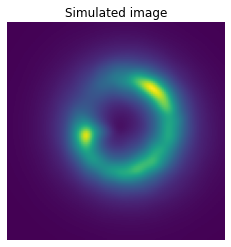

In [19]:
plt.imshow(dif_phase_perturbed_image, origin='lower')
plt.title('Simulated image')
plt.axis('off')

## Einstein ring Mask

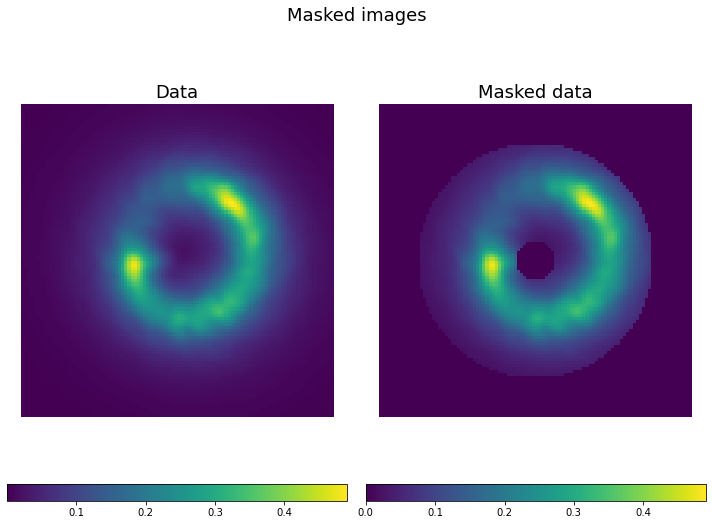

In [18]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(data_image, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(data_image*mask, origin='lower')
ax2.set_title("Masked data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [19]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

## Make the fit

In [20]:
learning_rate=5e-4
max_iter=200

model_loss_function_pure=purify_function(model_loss_function,data_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)

args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
fit_image=smooth_lens_image.model(**parameters.args2kwargs(args_fit))

## Extract spectrum

In [21]:
#Compute Target Power spectrum of data residuals 
data_resid=data_image-fit_image
data_resid_spectrum=compute_radial_spectrum_pure(data_resid)
#example_resid_spectrum=compute_radial_spectrum_pure(example_residuals)

Text(0.5, 1.0, 'Data power spectrum')

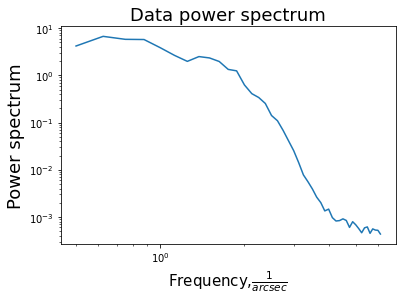

In [17]:
plt.loglog(masked_k_vector,data_resid_spectrum)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=15)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Data power spectrum',fontsize=FS)

Text(0, 0.5, 'Flux')

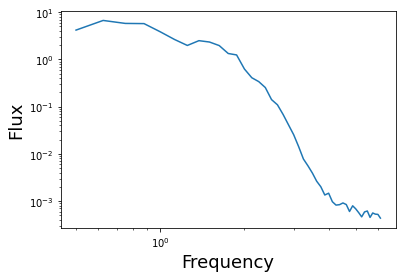

In [25]:
plt.loglog(masked_k_vector,data_resid_spectrum)
plt.xlabel('Frequency',fontsize=FS)
plt.ylabel('Flux',fontsize=FS)

In [26]:
plt.loglog(masked_k_vector,compute_radial_spectrum_pure(dif_phase_resid))
plt.xlabel('Wavenumber,' r'$\frac{1}{arcsec}$',fontsize=15)
#plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Simulated power spectrum',fontsize=FS)

NameError: name 'dif_phase_resid' is not defined

$\mathcal{L}(\widetilde{A},\widetilde{\beta},\widetilde{\phi})=||\frac{PS_{data}-PS_{simulation}(\widetilde{A},\widetilde{\beta},\widetilde{\phi})}{PS_{data}}||$

$\psi_0 \rightarrow \psi_1$  
$\psi_1 \rightarrow \psi_2$

Text(0.5, 1.0, 'Residuals power spectrum')

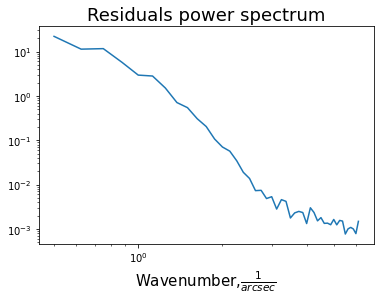

In [27]:
plt.loglog(masked_k_vector,example_resid_spectrum)
plt.xlabel('Wavenumber,' r'$\frac{1}{arcsec}$',fontsize=15)
#plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum',fontsize=FS)

$\psi_0$

## Fit spectrum with powerlaw to get Guess of GRF's Power slope

In [22]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,1.],args=(masked_k_vector,data_resid_spectrum))
GRF_init_guess=np.array(res.x)

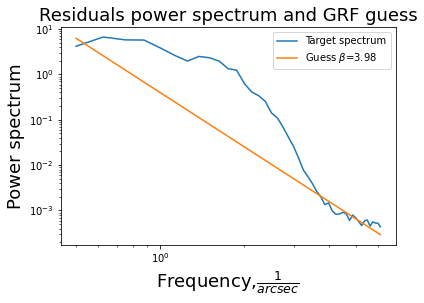

In [23]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,data_resid_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='Guess '+r'$\beta$'+'={:.2f}'.format(GRF_init_guess[1]))
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

# GRF phase realisation

## Phase related variance

In [366]:
def generate_spectrum(GRF_seed,GRF_params):
    GRF=get_jaxified_GRF_pure(GRF_params,GRF_seed)
    simulated_image=simulate_perturbed_image_pure(GRF)
    
    model_loss_function_pure=purify_function(model_loss_function,simulated_image,parameters,simulate_smooth_image_pure)
    model_loss_grad=jax.grad(model_loss_function_pure)
    
    args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
    unperturbed_image=simulate_smooth_image_pure(parameters.args2kwargs(args_fit))
    
    resid=simulated_image-unperturbed_image
    return compute_radial_spectrum_pure(resid)

In [367]:
Random_seeds=np.arange(2,102)
Spectra_for_seeds_LS=np.zeros((len(Random_seeds),len(data_resid_spectrum)))
Spectra_for_seeds_HS=np.zeros((len(Random_seeds),len(data_resid_spectrum)))


Spectra_for_seeds_LS=jax_map(lambda seed: generate_spectrum(seed,GRF_params),Random_seeds)
Spectra_for_seeds_HS=jax_map(lambda seed: generate_spectrum(seed,[-8.5,7.]),Random_seeds)

In [368]:
data_resid_spectrum_LS=deepcopy(data_resid_spectrum)
data_resid_spectrum_HS=deepcopy(example_resid_spectrum)

Text(0.5, 0, 'Frequency,$\\frac{1}{arcsec}$')

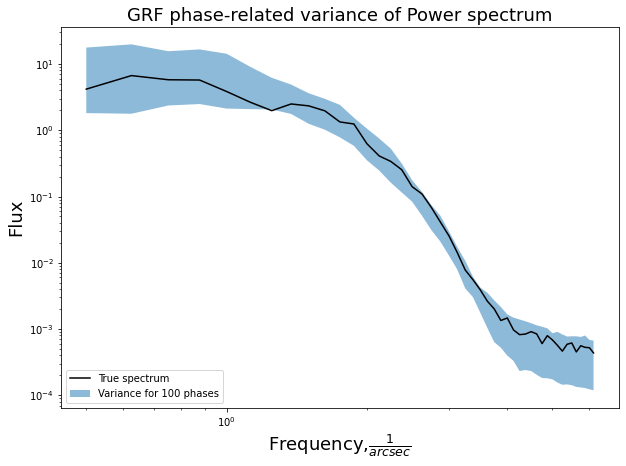

In [369]:
plt.figure(figsize=(10,7))
plt.plot(masked_k_vector,data_resid_spectrum_LS,color='black',label='True spectrum')
plt.fill_between(masked_k_vector,Spectra_for_seeds_LS.min(axis=0),Spectra_for_seeds_LS.max(axis=0),label='Variance for 100 phases',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
plt.ylabel('Flux',fontsize=FS)
plt.title('GRF phase-related variance of Power spectrum',fontsize=FS)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)

Text(0.5, 0, 'Frequency,$\\frac{1}{arcsec}$')

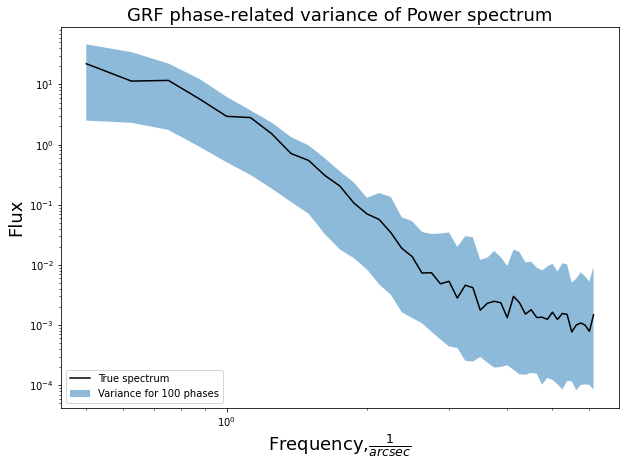

In [370]:
plt.figure(figsize=(10,7))
plt.plot(masked_k_vector,data_resid_spectrum_HS,color='black',label='True spectrum')
plt.fill_between(masked_k_vector,Spectra_for_seeds_HS.min(axis=0),Spectra_for_seeds_HS.max(axis=0),label='Variance for 100 phases',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
plt.ylabel('Flux',fontsize=FS)
plt.title('GRF phase-related variance of Power spectrum',fontsize=FS)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)

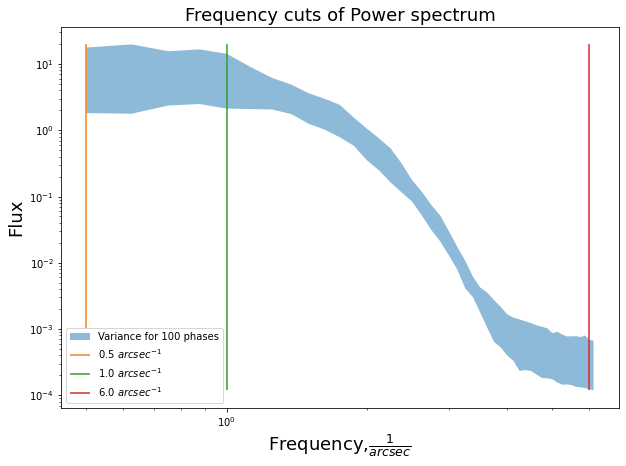

In [371]:
cut_index=[0,4,44]

plt.figure(figsize=(10,7))
plt.fill_between(masked_k_vector,Spectra_for_seeds_LS.min(axis=0),Spectra_for_seeds_LS.max(axis=0),label='Variance for 100 phases',alpha=0.5)

plt.vlines(masked_k_vector[cut_index[0]],1e-3,Spectra_for_seeds_LS.max(),color='C1',label='{:.1f} '.format(masked_k_vector[cut_index[0]])+r'$arcsec^{-1}$')
plt.vlines(masked_k_vector[cut_index[1]],Spectra_for_seeds_LS.min(),Spectra_for_seeds_LS.max(),color='C2',label='{:.1f} '.format(masked_k_vector[cut_index[1]])+r'$arcsec^{-1}$')
plt.vlines(masked_k_vector[cut_index[2]],Spectra_for_seeds_LS.min(),Spectra_for_seeds_LS.max(),color='C3',label='{:.1f} '.format(masked_k_vector[cut_index[2]])+r'$arcsec^{-1}$')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux',fontsize=FS)
plt.title('Frequency cuts of Power spectrum',fontsize=FS)
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)

leg=plt.legend(loc='lower left')

In [372]:
df_temp=pd.DataFrame()
for i in range(3):
    flux=Spectra_for_seeds_LS[:,cut_index[i]]
    flux-=flux.min()
    flux/=flux.max()
    freq_cut=pd.DataFrame(np.array([flux,np.full_like(flux,masked_k_vector[cut_index[i]])]).T)
    print(len(freq_cut))
    df_temp=df_temp.append(freq_cut)
df_temp.reset_index(inplace=True,drop=True)
df_temp.columns=['Flux','Frequency, '+r'$arcsec^{-1}$']



100
100
100


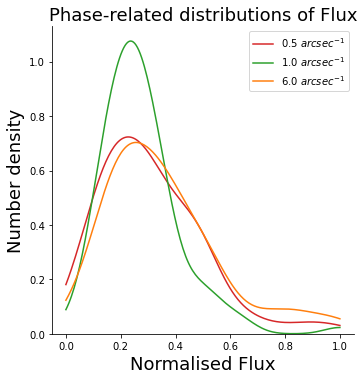

In [373]:
sns.displot(data=df_temp,x='Flux',hue='Frequency, '+r'$arcsec^{-1}$',kind='kde',cut=0,palette=['C1','C2','C3'],legend=False)
plt.xlabel('Normalised Flux',fontsize=FS)
plt.ylabel('Number density',fontsize=FS)
plt.title('Phase-related distributions of Flux',fontsize=FS)
plt.legend(['{:.1f} '.format(masked_k_vector[cut_index[i]])+r'$arcsec^{-1}$' for i in range(3)])

100
100
100


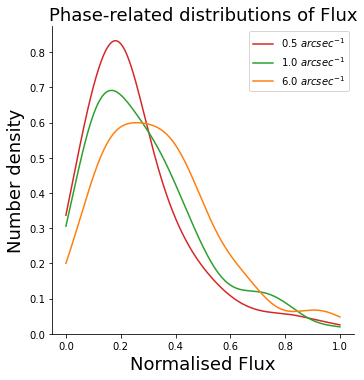

In [374]:
df_temp=pd.DataFrame()
for i in range(3):
    flux=Spectra_for_seeds_HS[:,cut_index[i]]
    flux-=flux.min()
    flux/=flux.max()
    freq_cut=pd.DataFrame(np.array([flux,np.full_like(flux,masked_k_vector[cut_index[i]])]).T)
    print(len(freq_cut))
    df_temp=df_temp.append(freq_cut)
df_temp.reset_index(inplace=True,drop=True)
df_temp.columns=['Flux','Frequency, '+r'$arcsec^{-1}$']


sns.displot(data=df_temp,x='Flux',hue='Frequency, '+r'$arcsec^{-1}$',kind='kde',cut=0,palette=['C1','C2','C3'],legend=False)
plt.xlabel('Normalised Flux',fontsize=FS)
plt.ylabel('Number density',fontsize=FS)
plt.title('Phase-related distributions of Flux',fontsize=FS)
plt.legend(['{:.1f} '.format(masked_k_vector[cut_index[i]])+r'$arcsec^{-1}$' for i in range(3)])

## Loss functions

### Losses

In [375]:
def internal_mean_SE(fit_samples):
    mean_fit=fit_samples.mean(axis=0)
    return np.nanmean(np.power((data_resid_spectrum-mean_fit)/data_resid_spectrum,2),axis=-1)

def external_mean_SE(fit_samples):
    return np.nanmean(np.power((data_resid_spectrum-fit_samples)/data_resid_spectrum,2),axis=(0,-1))


def external_mean_AE(fit_samples):
    Losses=np.abs((data_resid_spectrum-fit_samples)/data_resid_spectrum)
    return np.nanmean(Losses,axis=(0,-1))

def bootstrap_CI_func_shaped(data,func,draw_len,nbr_draws=1000):
    res = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        #indices = np.random.randint(0, len(data), draw_len)
        indices=np.random.choice(np.arange(len(data)),size=draw_len,replace=False)
        data_tmp = data[indices] 
        q=func(data_tmp)
        res[n] = func(data_tmp)

    return res.min(),res.mean(),res.max()

In [376]:
nbr_draws=1000
M=len(Random_seeds)

int_MSE_losses_on_phase=np.zeros((2,M,3))
ext_MSE_losses_on_phase=np.zeros((2,M,3))
ext_MAE_losses_on_phase=np.zeros((2,M,3))

selected_phases=np.linspace(1,M,M)

for i in tqdm(range(M)):
    #Low scale
    int_MSE_losses_on_phase[0,i]=bootstrap_CI_func_shaped(Spectra_for_seeds_LS, internal_mean_SE,draw_len=i+1)
    ext_MSE_losses_on_phase[0,i]=bootstrap_CI_func_shaped(Spectra_for_seeds_LS, external_mean_SE,draw_len=i+1)
    ext_MAE_losses_on_phase[0,i]=bootstrap_CI_func_shaped(Spectra_for_seeds_LS, external_mean_AE,draw_len=i+1)
    
    #High scale
    int_MSE_losses_on_phase[1,i]=bootstrap_CI_func_shaped(Spectra_for_seeds_HS, internal_mean_SE,draw_len=i+1)
    ext_MSE_losses_on_phase[1,i]=bootstrap_CI_func_shaped(Spectra_for_seeds_HS, external_mean_SE,draw_len=i+1)
    ext_MAE_losses_on_phase[1,i]=bootstrap_CI_func_shaped(Spectra_for_seeds_HS, external_mean_AE,draw_len=i+1)

100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


$\mathcal{L}(\widetilde{\phi},\overrightarrow{\phi})=\langle \ \left\vert \frac{Spectrum(\widetilde{\phi})-Spectrum(\overrightarrow{\phi})}{Spectrum(\widetilde{\phi})} \right\vert  \ \rangle_{\overrightarrow{\phi}}$

$\mathcal{L}(\widetilde{\phi},\overrightarrow{\phi})=\langle \ \left( \frac{Spectrum(\widetilde{\phi})-Spectrum(\overrightarrow{\phi})}{Spectrum(\widetilde{\phi})} \right)^2  \ \rangle_{\overrightarrow{\phi}}$

$\mathcal{L}(\widetilde{\phi},\overrightarrow{\phi})=\left( \frac{Spectrum(\widetilde{\phi})-\langle \ Spectrum(\overrightarrow{\phi})  \ \rangle_{\overrightarrow{\phi}}}{Spectrum(\widetilde{\phi})} \right)^2  $

In [377]:
losses=np.array([int_MSE_losses_on_phase,ext_MSE_losses_on_phase,ext_MAE_losses_on_phase])
loss_vars=(losses[:,:,:,2]-losses[:,:,:,0])/losses[:,:,:,1]
loss_names=[r'$\mathcal{L}=\left( \frac{data-\langle \ model \ (\overrightarrow{\phi})  \ \rangle_{\overrightarrow{\phi}}}{data} \right) ^2$',\
            r'$\mathcal{L}=\langle \ \left( \frac{data-model \ (\overrightarrow{\phi})}{data} \right)^2  \ \rangle_{\overrightarrow{\phi}}$',\
            r'$\mathcal{L}=\langle \ abs \left( \frac{data - model \ (\overrightarrow{\phi})}{data} \right)  \ \rangle_{\overrightarrow{\phi}}$']

$\mathcal{L}=MSE( \ \langle \ model(\overrightarrow{\phi}) \ \rangle_{\overrightarrow{\phi}} \ )$

$\mathcal{L}=\langle \ MSE(  \ model(\overrightarrow{\phi})  \ ) \ \rangle_{\overrightarrow{\phi}}$

$\mathcal{L}=\langle \ MAE(  \ model(\overrightarrow{\phi})  \ ) \ \rangle_{\overrightarrow{\phi}}$


In [378]:
loss_names=[r'$\mathcal{L}=MSE( \ \langle \ PS \ \rangle_{\overrightarrow{\phi}} \ )$',\
            r'$\mathcal{L}=\langle \ MSE(  \ PS  \ ) \ \rangle_{\overrightarrow{\phi}}$',\
            r'$\mathcal{L}=\langle \ MAE(  \ PS  \ ) \ \rangle_{\overrightarrow{\phi}}$']

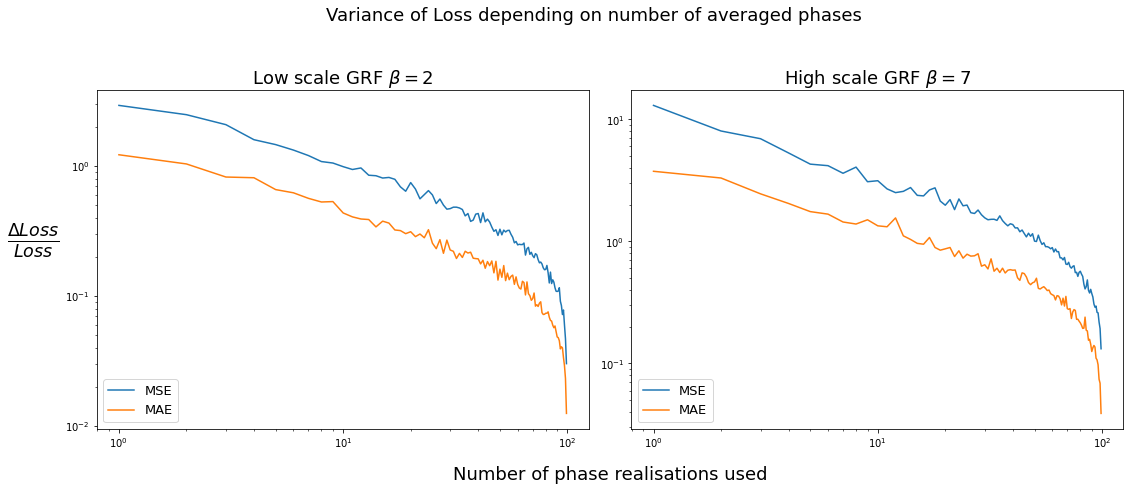

In [384]:
fig,ax=plt.subplots(1,2,figsize=(15,6))

fig_titles=['Low scale GRF ' r'$\beta=2$','High scale GRF '+ r'$\beta=7$',]

loss_names=['','MSE','MAE']

for i,loss_var in enumerate(loss_vars):
    if i==0:
        continue
    for j in range(2):
        ax[j].plot(selected_phases[:-1],loss_var[j,:-1],label=loss_names[i])
        ax[j].set_title(fig_titles[j],fontsize=FS)
        ax[j].legend(fontsize=13,loc='lower left')
        
        ax[j].set_yscale('log')
        ax[j].set_xscale('log')
        

fig.suptitle('Variance of Loss depending on number of averaged phases',fontsize=FS,y=1.05)
fig.tight_layout()  

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of phase realisations used',labelpad=20,fontsize=FS)
plt.ylabel(r'$\frac{\Delta Loss}{Loss}$',labelpad=40,rotation=0,fontsize=25)
plt.show()

### Phase numbers for beta=2

In [385]:
print('MAE relative variance <1 for %d phases'%selected_phases[np.where(loss_vars[-1,0]<1)[0][0]])
print('MAE relative variance <0.1 for %d phases'%selected_phases[np.where(loss_vars[-1,0]<0.1)[0][0]])

MAE relative variance <1 for 3 phases
MAE relative variance <0.1 for 69 phases


In [386]:
print('MSE relative variance <1 for %d phases'%selected_phases[np.where(loss_vars[1,0]<1)[0][0]])
print('MSE relative variance <0.1 for %d phases'%selected_phases[np.where(loss_vars[1,0]<0.1)[0][0]])

MSE relative variance <1 for 10 phases
MSE relative variance <0.1 for 93 phases


### Phase numbers for beta=7

In [387]:
print('MAE relative variance <1 for %d phases'%selected_phases[np.where(loss_vars[-1,1]<1)[0][0]])
print('MAE relative variance <0.1 for %d phases'%selected_phases[np.where(loss_vars[-1,1]<0.1)[0][0]])

MAE relative variance <1 for 15 phases
MAE relative variance <0.1 for 96 phases


In [388]:
print('MSE relative variance <1 for %d phases'%selected_phases[np.where(loss_vars[1,1]<1)[0][0]])
print('MSE relative variance <0.1 for %d phases'%selected_phases[np.where(loss_vars[1,1]<0.1)[0][0]])

MSE relative variance <1 for 51 phases
MSE relative variance <0.1 for 100 phases


# GRF Loss phase dependence

In [3]:
A_array=np.linspace(-8.,-6.,100)
Beta_array=np.linspace(0.5,3.5,100)

y_labels=np.round(A_array,9)
x_labels=np.round(Beta_array,2)


num_ticks = 10
# the index of the position of yticks
ticks = np.linspace(0, 100 - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

In [4]:
def pure_Loss_from_seed(Seeds_number,Spectra_Loss_pure):
    GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)
    simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)
    
    GRF_Loss_args=(GRF_seeds,unperturbed_data_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure,compute_radial_spectrum_pure,Spectra_Loss_pure)

    #Precompile GRF_Loss 
    GRF_Loss_pure=purify_function(GRF_Loss_phase_averaging,*GRF_Loss_args)
    return GRF_Loss_pure

In [5]:
def merge_arrays_by_index(index_arr_1,index_arr_2,values_arr_1,values_arr_2):
    complete_index=np.append(index_arr_1,index_arr_2)
    sort_index=np.argsort(complete_index)
    
    complete_values=np.append(values_arr_1,values_arr_2,axis=0)
    
    return complete_index[sort_index],complete_values[sort_index]

In [6]:
lin_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_loss_seeds_grid.npy',allow_pickle=True)
lin_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_seeds_numbers.npy',allow_pickle=True)

In [7]:
log_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/loss_seeds_grid.npy',allow_pickle=True)
log_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/seeds_numbers.npy',allow_pickle=True)

In [8]:
Seeds_numbers,loss_seeds_grid=merge_arrays_by_index(lin_Seeds_numbers,log_Seeds_numbers,lin_loss_seeds_grid,log_loss_seeds_grid)
Seeds_numbers=Seeds_numbers[1:]
loss_seeds_grid=loss_seeds_grid[1:]

In [9]:
Seeds_numbers

array([ 1,  2,  3,  4,  5,  7,  8, 10, 13, 14, 17, 20, 22])

In [10]:
loss_grid_indices=[0,-2]
i=1

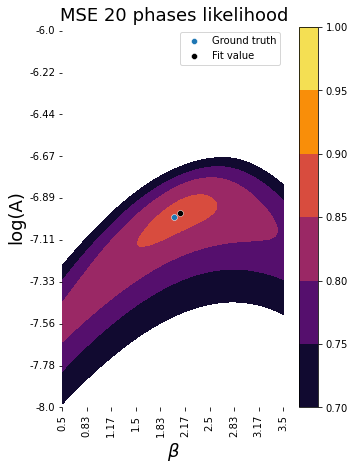

In [11]:
    plt.figure(figsize=(5,7))
    loss_grid=loss_seeds_grid[loss_grid_indices[i]]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=plt.contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    
    
    sns.scatterplot(x=[50],y=[50],label='Ground truth')
    sns.scatterplot(x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    plt.legend()
    
    plt.xlabel(r'$\beta$',fontsize=FS)
    plt.ylabel('log(A)',fontsize=FS)
    
    plt.gca().invert_yaxis()
    set_labels(im)
    plt.title('MSE %d phases likelihood'%(Seeds_numbers[loss_grid_indices[i]]),fontsize=FS)
    plt.colorbar()

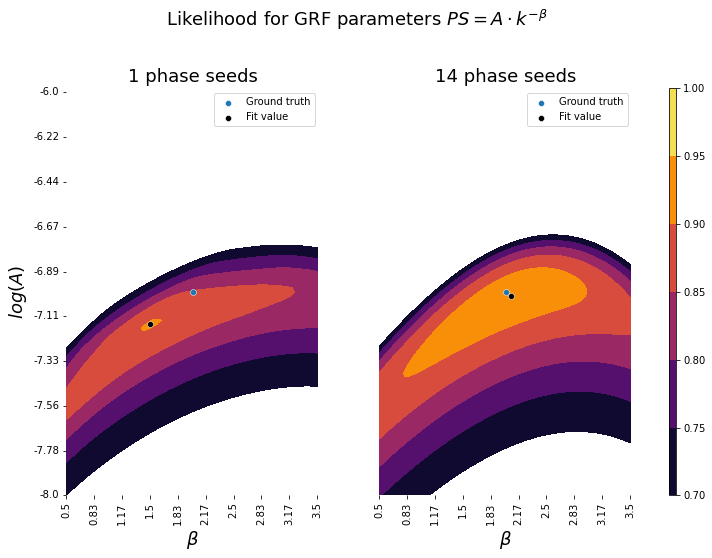

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax=plt.subplots(1,2,figsize=(10,7))

loss_grid_indices=[0,-4]

for i in range(0,2):
    loss_grid=loss_seeds_grid[loss_grid_indices[i]]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i],data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=ax[i].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    
    
    sns.scatterplot(ax=ax[i],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i],x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    ax[i].legend()
    
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    
    ax[i].invert_yaxis()
    set_labels(im)
    ax[i].set_title('%d phase seeds'%(Seeds_numbers[loss_grid_indices[i]]),fontsize=FS)
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="3%", pad=0.5)
    if i==1:
        plt.colorbar(ct, cax=cax)
    else:
        cax.axis('off')


ax[0].set_ylabel(r'$log(A)$',fontsize=FS)
ax[1].axes.get_yaxis().set_visible(False)

#fig.colorbar(ct,ax=ax[1])
fig.tight_layout()
fig.suptitle('Likelihood for GRF parameters '+r'$PS=A \cdot k^{-\beta}$',y=1.1,fontsize=FS)
plt.show()

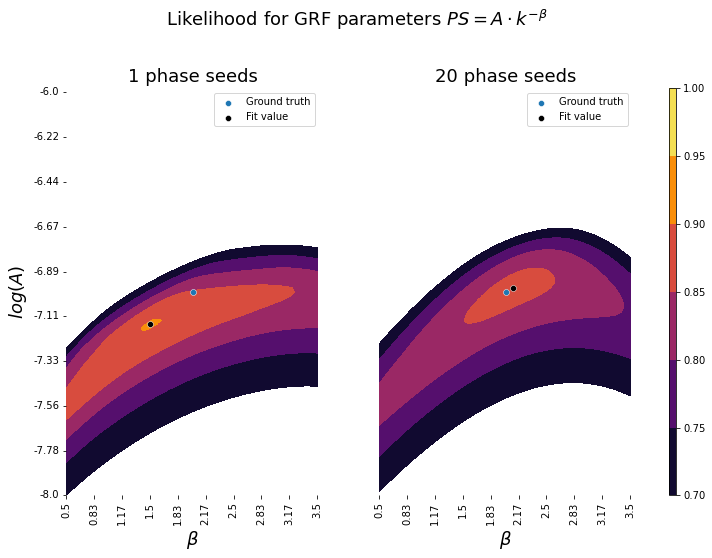

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,ax=plt.subplots(1,2,figsize=(10,7))

loss_grid_indices=[0,-2]

for i in range(0,2):
    loss_grid=loss_seeds_grid[loss_grid_indices[i]]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i],data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=ax[i].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    
    
    sns.scatterplot(ax=ax[i],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i],x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    ax[i].legend()
    
    ax[i].set_xlabel(r'$\beta$',fontsize=FS)
    
    ax[i].invert_yaxis()
    set_labels(im)
    ax[i].set_title('%d phase seeds'%(Seeds_numbers[loss_grid_indices[i]]),fontsize=FS)
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="3%", pad=0.5)
    if i==1:
        plt.colorbar(ct, cax=cax)
    else:
        cax.axis('off')


ax[0].set_ylabel(r'$log(A)$',fontsize=FS)
ax[1].axes.get_yaxis().set_visible(False)

#fig.colorbar(ct,ax=ax[1])
fig.tight_layout()
fig.suptitle('Likelihood for GRF parameters '+r'$PS=A \cdot k^{-\beta}$',y=1.1,fontsize=FS)
plt.show()

In [148]:
Laplace_likelihood_grid=np.exp(-loss_seeds_grid[-2]/2)
Gaussian_loss_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_loss_seeds_grid.npy',allow_pickle=True)[-1]
Gaussian_likelihood_grid=np.exp(-Gaussian_loss_grid/2)

xdata=np.power(10,A_array)

### likelihoods on extended grids

In [64]:
likelihood=Laplace_likelihood_grid
fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

Laplace_Beta=Beta_array[fit_j]
Laplace_LogA=A_array[fit_i]

Laplace_Amp_likelihood=likelihood[:,fit_j]
Laplace_Beta_likelihood=likelihood[fit_i,:]

In [204]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,compute_radial_spectrum_pure(data_image-unperturbed_data_image))
GRF_Loss_pure=pure_Loss_from_seed(20,Spectra_Loss_pure)

GRF_absence_Laplace_likelihood=np.exp(-(GRF_Loss_pure([-np.inf,Laplace_Beta]))/2)

additional_Beta_array=np.append([0],np.arange(4,7.25,0.25)).astype(float)
additional_GRF_params=np.append([np.full_like(additional_Beta_array,Laplace_LogA)],[additional_Beta_array],axis=0).T

additional_Laplace_loss=jax_map(GRF_Loss_pure,additional_GRF_params)
additional_Laplace_Beta_likelihood=np.exp(-additional_Laplace_loss/2)

In [205]:
complete_Beta_array,complete_Laplace_Beta_likelihood=merge_arrays_by_index(Beta_array,additional_Beta_array,Laplace_Beta_likelihood,additional_Laplace_Beta_likelihood)
complete_A_array,complete_Laplace_Amp_likelihood=merge_arrays_by_index(A_array,[-np.inf],Laplace_Amp_likelihood,[GRF_absence_Laplace_likelihood])

In [209]:
likelihood=Gaussian_likelihood_grid
fit_i,fit_j=np.where(likelihood==likelihood.max())
fit_i=fit_i.item()
fit_j=fit_j.item()

Gaussian_Beta=Beta_array[fit_j]
Gaussian_logA=A_array[fit_i]

Gaussian_Amp_likelihood=likelihood[:,fit_j]
Gaussian_Beta_likelihood=likelihood[fit_i,:]

In [210]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,compute_radial_spectrum_pure(data_image-unperturbed_data_image))
GRF_Loss_pure=pure_Loss_from_seed(20,Spectra_Loss_pure)

GRF_absence_Gaussian_likelihood=np.exp(-(GRF_Loss_pure([-np.inf,Gaussian_Beta]))/2)

additional_Beta_array=np.append([0],np.arange(4,7.25,0.25)).astype(float)
additional_GRF_params=np.append([np.full_like(additional_Beta_array,Gaussian_logA)],[additional_Beta_array],axis=0).T

additional_Gaussian_loss=jax_map(GRF_Loss_pure,additional_GRF_params)
additional_Gaussian_Beta_likelihood=np.exp(-additional_Gaussian_loss/2)

In [211]:
_,complete_Gaussian_Beta_likelihood=merge_arrays_by_index(Beta_array,additional_Beta_array,Gaussian_Beta_likelihood,additional_Gaussian_Beta_likelihood)
_,complete_Gaussian_Amp_likelihood=merge_arrays_by_index(A_array,[-np.inf],Gaussian_Amp_likelihood,[GRF_absence_Gaussian_likelihood])

## fits

In [287]:
import scipy 

def laplace(xdata,*params):
    amplitude,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.laplace.pdf(x)

def gennorm(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.gennorm.pdf(x,s)

def norm(xdata,*params):
    amplitude,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.norm.pdf(x)
    

def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def loglaplace(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.loglaplace.pdf(x,s)


def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers where scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
        
    elif distr_func=='gennorm':
        func=gennorm
        init_guess=[1,1.,1.,1]
        
    elif distr_func=='loglaplace':
        func=loglaplace
        init_guess=[1,1.,1.,1]
        
    elif distr_func=='laplace':
        func=laplace
        init_guess=[1,1.,1.]
        
    elif distr_func=='normal':
        func=norm
        init_guess=[1,1.,1.]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if np.isin(distr_func,['lognormal','loglaplace','gennorm']):
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier
    else:
        amplitude,loc,scale=popt
        return amplitude,loc/multiplier,scale/multiplier
        
        
        
def fit_Laplace_likelihood(xdata,ydata,Poisson_errs=False):

    init_guess=[1.,xdata[len(xdata)//2],1.,1.]
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(skewed_Laplace,xdata,ydata,init_guess,bounds=(bounds_low,bounds_high),sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(skewed_Laplace,xdata,ydata,init_guess,bounds=(bounds_low,bounds_high))
    return popt


def fit_LogNormal_likelihood(xdata,ydata,Poisson_errs=False,multiplier=None):

    #It is a trick to fit distributions in very small numbers where scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
    
    init_guess=[1,1.,0.,1]
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(lognormal,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(lognormal,x,ydata,init_guess)
        
    amplitude,s,loc,scale=popt
    
    return amplitude,s,loc/multiplier,scale/multiplier

def fit_LogLaplace_likelihood(xdata,ydata,Poisson_errs=False,multiplier=None):

    #It is a trick to fit distributions in very small numbers where scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
    
    init_guess=[1,1.,1.,1]
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(loglaplace,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(loglaplace,x,ydata,init_guess)
        
    amplitude,s,loc,scale=popt
    
    return amplitude,s,loc/multiplier,scale/multiplier

### MAE

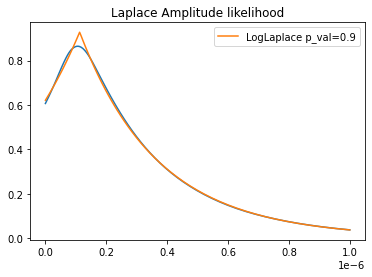

In [284]:
xdata=np.power(10,complete_A_array)
ydata=complete_Laplace_Amp_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='loglaplace',Poisson_errs=True)
y_fit=loglaplace(xdata,*popt)

plt.plot(xdata,ydata)
plt.plot(xdata,y_fit,label='LogLaplace p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
plt.title('Laplace Amplitude likelihood')
plt.legend()

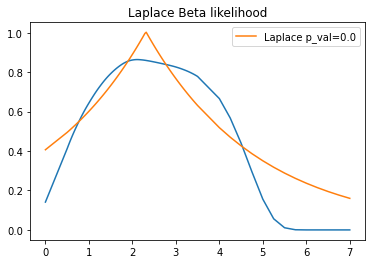

In [286]:
xdata=complete_Beta_array
ydata=complete_Laplace_Beta_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='laplace',Poisson_errs=False)
y_fit=laplace(xdata,*popt)

plt.plot(xdata,ydata)
plt.plot(xdata,y_fit,label='Laplace p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
plt.title('Laplace Beta likelihood')
plt.legend()

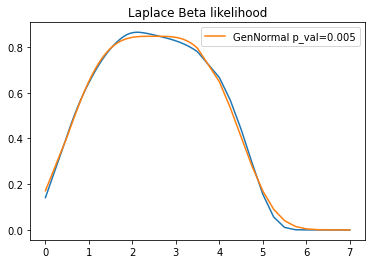

In [294]:
xdata=complete_Beta_array
ydata=complete_Laplace_Beta_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='gennorm',Poisson_errs=False)
y_fit=gennorm(xdata,*popt)

plt.plot(xdata,ydata)
plt.plot(xdata,y_fit,label='GenNormal p_val={:.3f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
plt.title('Laplace Beta likelihood')
plt.legend()

### MSE

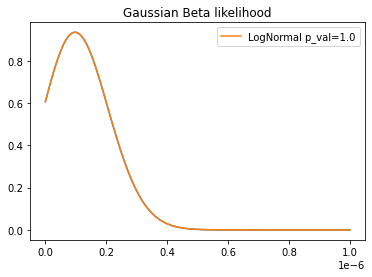

In [289]:
xdata=np.power(10,complete_A_array)
ydata=complete_Gaussian_Amp_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='lognormal',Poisson_errs=False)
y_fit=lognormal(xdata,*popt)

plt.plot(xdata,ydata)
plt.plot(xdata,y_fit,label='LogNormal p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
plt.title('Gaussian Beta likelihood')
plt.legend()

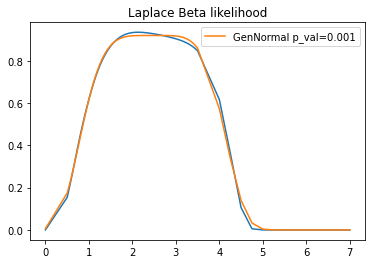

In [293]:
xdata=complete_Beta_array
ydata=complete_Gaussian_Beta_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='gennorm',Poisson_errs=False)
y_fit=gennorm(xdata,*popt)

plt.plot(xdata,ydata)
plt.plot(xdata,y_fit,label='GenNormal p_val={:.3f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
plt.title('Laplace Beta likelihood')
plt.legend()

### Likelihoods

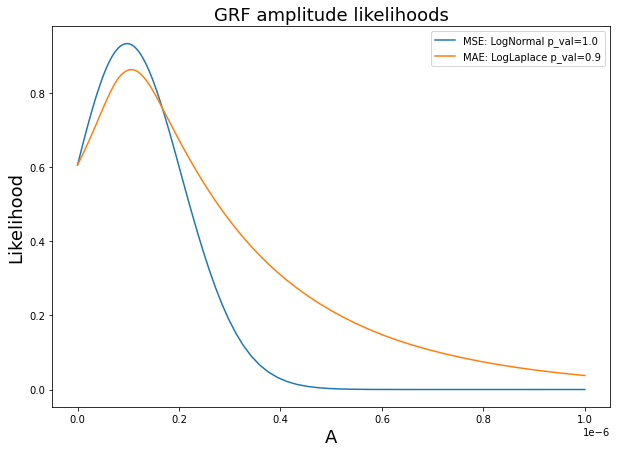

In [295]:
plt.figure(figsize=(10,7))

xdata=np.power(10,complete_A_array)
ydata=complete_Gaussian_Amp_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='lognormal',Poisson_errs=False)
y_fit=lognormal(xdata,*popt)

plt.plot(xdata,ydata,label='MSE: LogNormal p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))

xdata=np.power(10,complete_A_array)
ydata=complete_Laplace_Amp_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='loglaplace',Poisson_errs=True)
y_fit=loglaplace(xdata,*popt)

plt.plot(xdata,ydata,label='MAE: LogLaplace p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))

plt.xlabel('A',fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.title('GRF amplitude likelihoods',fontsize=FS)

plt.legend()

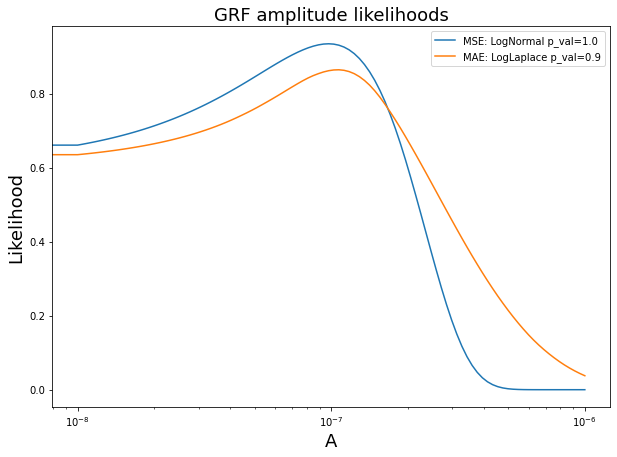

In [343]:
plt.figure(figsize=(10,7))

xdata=np.power(10,complete_A_array)
ydata=complete_Gaussian_Amp_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='lognormal',Poisson_errs=False)
y_fit=lognormal(xdata,*popt)

plt.plot(xdata,ydata,label='MSE: LogNormal p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))
plt.xscale('log')

xdata=np.power(10,complete_A_array)
ydata=complete_Laplace_Amp_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='loglaplace',Poisson_errs=True)
y_fit=loglaplace(xdata,*popt)

plt.plot(xdata,ydata,label='MAE: LogLaplace p_val={:.1f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))

plt.xlabel('A',fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.title('GRF amplitude likelihoods',fontsize=FS)

plt.legend()

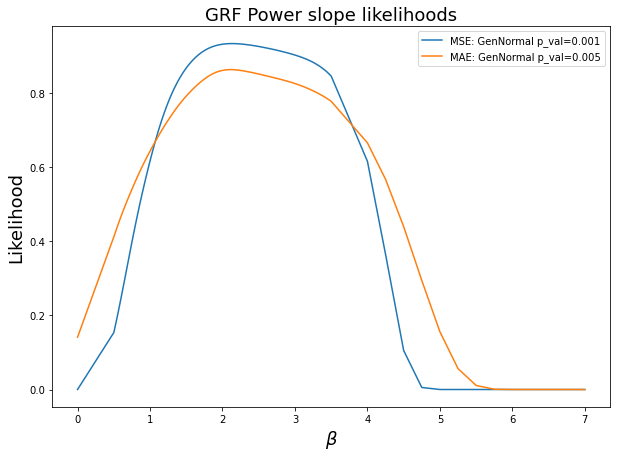

In [301]:
plt.figure(figsize=(10,7))

xdata=complete_Beta_array
ydata=complete_Gaussian_Beta_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='gennorm',Poisson_errs=False)
y_fit=gennorm(xdata,*popt)

plt.plot(xdata,ydata,label='MSE: GenNormal p_val={:.3f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))


xdata=complete_Beta_array
ydata=complete_Laplace_Beta_likelihood
popt=fit_likelihood(xdata,ydata,distr_func='gennorm',Poisson_errs=False)
y_fit=gennorm(xdata,*popt)

plt.plot(xdata,ydata,label='MAE: GenNormal p_val={:.3f}'.format(scipy.stats.ks_2samp(ydata,y_fit)[1]))


plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel('Likelihood',fontsize=FS)
plt.title('GRF Power slope likelihoods',fontsize=FS)

plt.legend()

In [346]:
def get_cdf(likelihood):
    cdf=np.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]
    
    return normalised_cdf

def get_conf_intervals(xdata,likelihood,center='median',percentage_covered=68.):
    
    cdf=get_cdf(likelihood)
    indent=np.minimum(0.5,percentage_covered/200.)
    
    if center=='median':
        value_index=np.where(cdf>=0.5)[0][0]
    elif center=='max':
        value_index=np.argmax(likelihood)
    else:
        print('wrong center')
        return None
        
    value=xdata[value_index]
    cdf_value=cdf[value_index]
    upper_bound=xdata[np.where(cdf<=cdf_value+indent)[0][-1]]
    lower_bound=xdata[np.where(cdf>=cdf_value-indent)[0][0]]
    
    upper_add=upper_bound-value
    lower_add=value-lower_bound
    return lower_add,value,upper_add

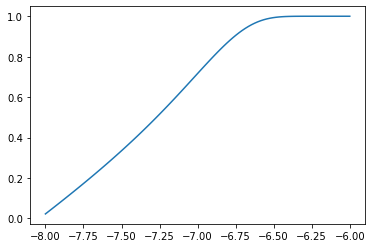

In [351]:
plt.plot(complete_A_array,get_cdf(complete_Gaussian_Amp_likelihood))

In [357]:
get_conf_intervals(complete_A_array,complete_Gaussian_Amp_likelihood,center='median',percentage_covered=68.)

(0.4848484848484844, -7.252525252525253, 0.42424242424242387)

In [353]:
get_conf_intervals(complete_Beta_array,complete_Gaussian_Beta_likelihood,center='median',percentage_covered=68.)

(0.9090909090909094, 2.1969696969696972, 0.8787878787878785)

In [355]:
get_conf_intervals(complete_A_array,complete_Laplace_Amp_likelihood,center='median',percentage_covered=68.)

(0.5454545454545459, -7.171717171717171, 0.4848484848484844)

In [356]:
get_conf_intervals(complete_Beta_array,complete_Laplace_Beta_likelihood,center='median',percentage_covered=68.)

(0.96969696969697, 2.166666666666667, 0.939393939393939)

True values $log(A)=-7$ ,  $\beta=2$


Gaussian likelihood predicts $log(A)=-7.25 ^{+0.42} _{-0.49}$ ,  $\beta=2.2^{+0.88} _{-0.91}$    


Laplace likelihood predicts $log(A)=-7.17 ^{+0.48} _{-0.55}$ ,  $\beta=2.16^{+0.93} _{-1}$   



## Phase number dependence

### MAE

In [400]:
lin_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_loss_seeds_grid.npy',allow_pickle=True)
lin_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/lin_seeds_numbers.npy',allow_pickle=True)

In [401]:
log_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/loss_seeds_grid.npy',allow_pickle=True)
log_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MAE/seeds_numbers.npy',allow_pickle=True)

In [402]:
Seeds_numbers,loss_seeds_grid=merge_arrays_by_index(lin_Seeds_numbers,log_Seeds_numbers,lin_loss_seeds_grid,log_loss_seeds_grid)
Seeds_numbers=Seeds_numbers[1:]
loss_seeds_grid=loss_seeds_grid[1:]

In [407]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,compute_radial_spectrum_pure(data_image-unperturbed_data_image))
GRF_Loss_pure=pure_Loss_from_seed(20,Spectra_Loss_pure)

In [418]:
likelihood_LogAmps_scales=np.zeros(len(Seeds_numbers))
likelihood_Beta_scales=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_errors=np.zeros(len(Seeds_numbers))
likelihood_Beta_errors=np.zeros(len(Seeds_numbers))

additional_A_array=[-np.inf]
additional_GRF_params=np.append([additional_A_array],[np.full_like(additional_A_array,Gaussian_logA)],axis=0).T


additional_Beta_array=np.append([0],np.arange(4,7.25,0.25)).astype(float)
additional_GRF_params=np.append([np.full_like(additional_Beta_array,Gaussian_logA)],[additional_Beta_array],axis=0).T


def find_likelihood_params(xdata,likelihood,additional_xdata,additional_GRF_params,Seed_number,Spectra_Loss_pure):
    
    GRF_Loss_pure=pure_Loss_from_seed(Seed_number,Spectra_Loss_pure)
    
    additional_loss=jax_map(GRF_Loss_pure,additional_GRF_params)
    additional_likelihood=np.exp(-additional_loss/2)
    
    complete_xdata,complete_likelihood=merge_arrays_by_index(xdata,additional_xdata,likelihood,additional_likelihood)
    
    lower_add,value,upper_add=get_conf_intervals(complete_xdata,complete_likelihood,center='median',percentage_covered=68.)
    
    
    return value,upper_add+lower_add

In [421]:
for i in tqdm(range(len(Seeds_numbers))):
    
    likelihood=np.exp(-loss_seeds_grid[i]/2)
    fit_i,fit_j=np.where(likelihood==likelihood.max())
    fit_i=fit_i.item()
    fit_j=fit_j.item()
    
    likelihood_logA=likelihood[:,fit_j]
    likelihood_Beta=likelihood[fit_i,:]
    
    additional_A_array=[-np.inf]
    additional_GRF_params=np.append([additional_A_array],[np.full_like(additional_A_array,Beta_array[fit_j])],axis=0).T
    
    logA,logA_scale=find_likelihood_params(A_array,likelihood_logA,additional_A_array,additional_GRF_params,Seeds_numbers[i],Spectra_Loss_pure)
    
    
    additional_Beta_array=np.append([0],np.arange(4,7.25,0.25)).astype(float)
    additional_GRF_params=np.append([np.full_like(additional_Beta_array,A_array[fit_i])],[additional_Beta_array],axis=0).T

    Beta,Beta_scale=find_likelihood_params(Beta_array,likelihood_Beta,additional_Beta_array,additional_GRF_params,Seeds_numbers[i],Spectra_Loss_pure)
    
    
    likelihood_LogAmps_errors[i]=GRF_LogAmp-A_array[fit_i]
    likelihood_Beta_errors[i]=GRF_beta-Beta_array[fit_j]
    
    likelihood_LogAmps_scales[i]=logA_scale
    likelihood_Beta_scales[i]=Beta_scale

100%|███████████████████████████████████████████| 13/13 [01:11<00:00,  5.49s/it]


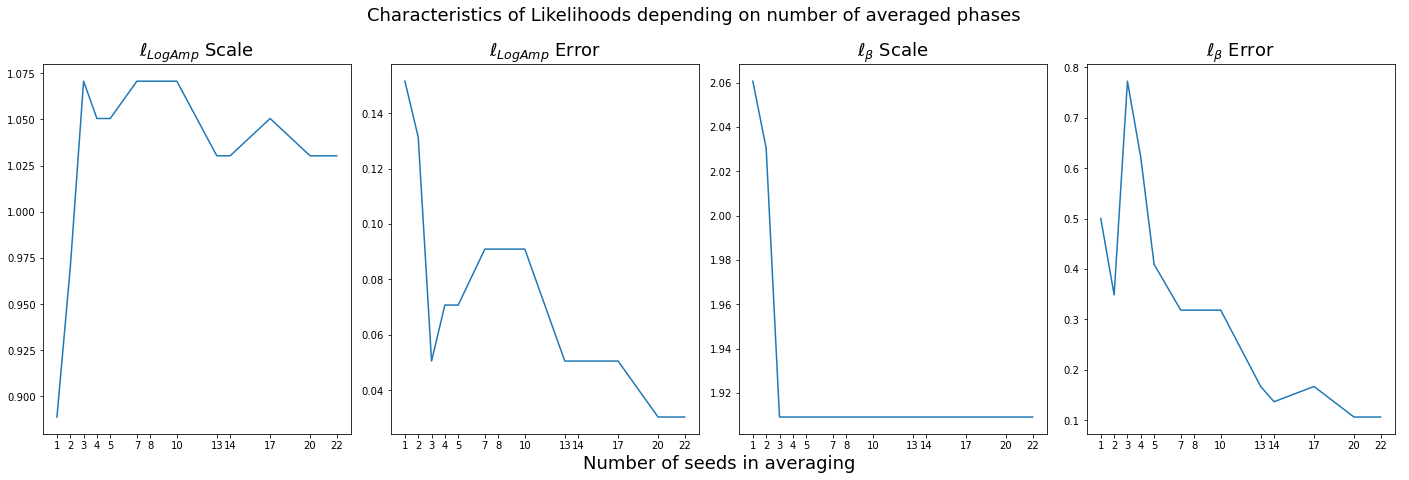

In [423]:
fig,ax=plt.subplots(1,4,figsize=(20,7))

ax[0].plot(Seeds_numbers,likelihood_LogAmps_scales)
ax[0].set_title(r'$\ell_{LogAmp}$'+' Scale',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title(r'$\ell_{LogAmp}$'+' Error',fontsize=FS)


ax[2].plot(Seeds_numbers,likelihood_Beta_scales)
ax[2].set_title(r'$\ell_{\beta}$'+' Scale',fontsize=FS)

ax[3].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[3].set_title(r'$\ell_{\beta}$'+' Error',fontsize=FS)


for i in range(4):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('Characteristics of Likelihoods depending on number of averaged phases',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of seeds in averaging',fontsize=FS)

fig.tight_layout()
plt.show()

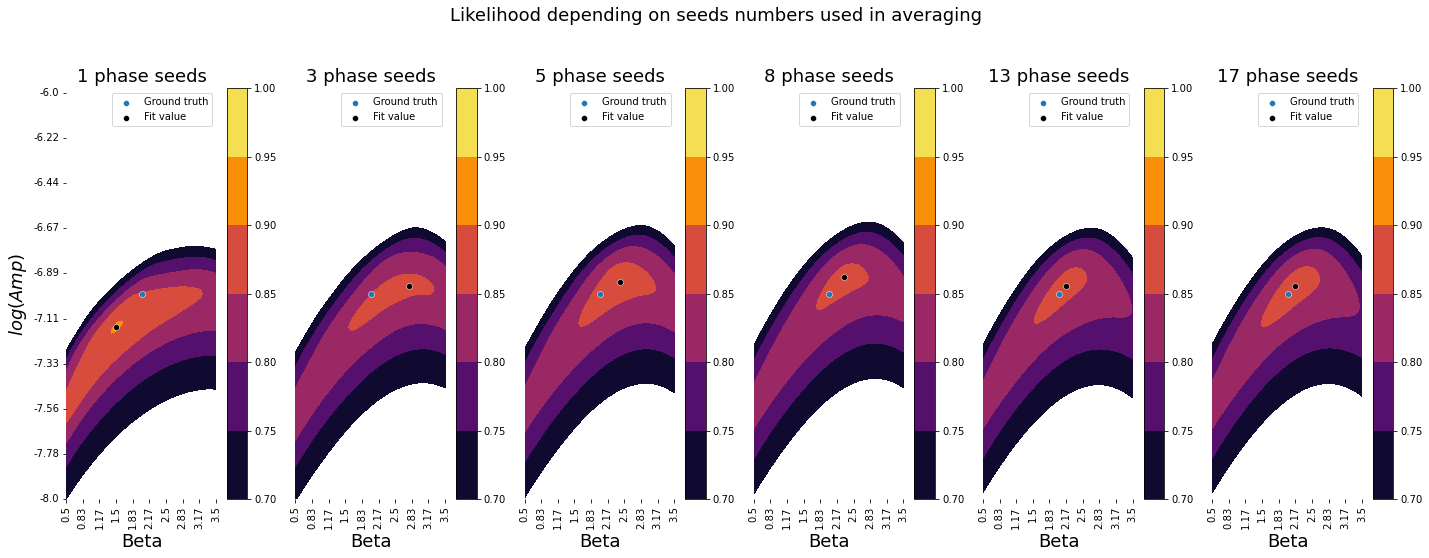

In [424]:
even_num=2*(len(loss_seeds_grid)//2)

fig,ax=plt.subplots(1,even_num//2,figsize=(20,7))

for i in range(0,even_num,2):
    i_fig=i//2
    loss_grid=loss_seeds_grid[i]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i_fig],data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=ax[i_fig].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    fig.colorbar(ct,ax=ax[i_fig])
    
    sns.scatterplot(ax=ax[i_fig],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i_fig],x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    ax[i_fig].legend()
    ax[i_fig].set_title('%d phase seeds'%(Seeds_numbers[i]),fontsize=FS)
    ax[i_fig].set_xlabel('Beta',fontsize=FS)
    ax[i_fig].set_ylabel(r'$log(Amp)$',fontsize=FS)
    ax[i_fig].invert_yaxis()
    if i_fig>0:
        ax[i_fig].axes.get_yaxis().set_visible(False)
    
    set_labels(im)
    
fig.tight_layout()
fig.suptitle('Likelihood depending on seeds numbers used in averaging',y=1.1,fontsize=FS)
plt.show()

### MSE

In [425]:
lin_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_loss_seeds_grid.npy',allow_pickle=True)
lin_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/lin_seeds_numbers.npy',allow_pickle=True)

In [426]:
log_loss_seeds_grid=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/loss_seeds_grid.npy',allow_pickle=True)
log_Seeds_numbers=np.load(Folder+'Data/Phase_averaging/Phase_number_studying/MSE/seeds_numbers.npy',allow_pickle=True)

In [427]:
Seeds_numbers,loss_seeds_grid=merge_arrays_by_index(lin_Seeds_numbers,log_Seeds_numbers,lin_loss_seeds_grid,log_loss_seeds_grid)
Seeds_numbers=Seeds_numbers[1:]
loss_seeds_grid=loss_seeds_grid[1:]

In [429]:
Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,compute_radial_spectrum_pure(data_image-unperturbed_data_image))

In [430]:
likelihood_LogAmps_scales=np.zeros(len(Seeds_numbers))
likelihood_Beta_scales=np.zeros(len(Seeds_numbers))

likelihood_LogAmps_errors=np.zeros(len(Seeds_numbers))
likelihood_Beta_errors=np.zeros(len(Seeds_numbers))

additional_A_array=[-np.inf]
additional_GRF_params=np.append([additional_A_array],[np.full_like(additional_A_array,Gaussian_logA)],axis=0).T


additional_Beta_array=np.append([0],np.arange(4,7.25,0.25)).astype(float)
additional_GRF_params=np.append([np.full_like(additional_Beta_array,Gaussian_logA)],[additional_Beta_array],axis=0).T


def find_likelihood_params(xdata,likelihood,additional_xdata,additional_GRF_params,Seed_number,Spectra_Loss_pure):
    
    GRF_Loss_pure=pure_Loss_from_seed(Seed_number,Spectra_Loss_pure)
    
    additional_loss=jax_map(GRF_Loss_pure,additional_GRF_params)
    additional_likelihood=np.exp(-additional_loss/2)
    
    complete_xdata,complete_likelihood=merge_arrays_by_index(xdata,additional_xdata,likelihood,additional_likelihood)
    
    lower_add,value,upper_add=get_conf_intervals(complete_xdata,complete_likelihood,center='median',percentage_covered=68.)
    
    
    return value,upper_add+lower_add

In [431]:
for i in tqdm(range(len(Seeds_numbers))):
    
    likelihood=np.exp(-loss_seeds_grid[i]/2)
    fit_i,fit_j=np.where(likelihood==likelihood.max())
    fit_i=fit_i.item()
    fit_j=fit_j.item()
    
    likelihood_logA=likelihood[:,fit_j]
    likelihood_Beta=likelihood[fit_i,:]
    
    additional_A_array=[-np.inf]
    additional_GRF_params=np.append([additional_A_array],[np.full_like(additional_A_array,Beta_array[fit_j])],axis=0).T
    
    logA,logA_scale=find_likelihood_params(A_array,likelihood_logA,additional_A_array,additional_GRF_params,Seeds_numbers[i],Spectra_Loss_pure)
    
    
    additional_Beta_array=np.append([0],np.arange(4,7.25,0.25)).astype(float)
    additional_GRF_params=np.append([np.full_like(additional_Beta_array,A_array[fit_i])],[additional_Beta_array],axis=0).T

    Beta,Beta_scale=find_likelihood_params(Beta_array,likelihood_Beta,additional_Beta_array,additional_GRF_params,Seeds_numbers[i],Spectra_Loss_pure)
    
    
    likelihood_LogAmps_errors[i]=GRF_LogAmp-A_array[fit_i]
    likelihood_Beta_errors[i]=GRF_beta-Beta_array[fit_j]
    
    likelihood_LogAmps_scales[i]=logA_scale
    likelihood_Beta_scales[i]=Beta_scale

100%|███████████████████████████████████████████| 13/13 [01:11<00:00,  5.51s/it]


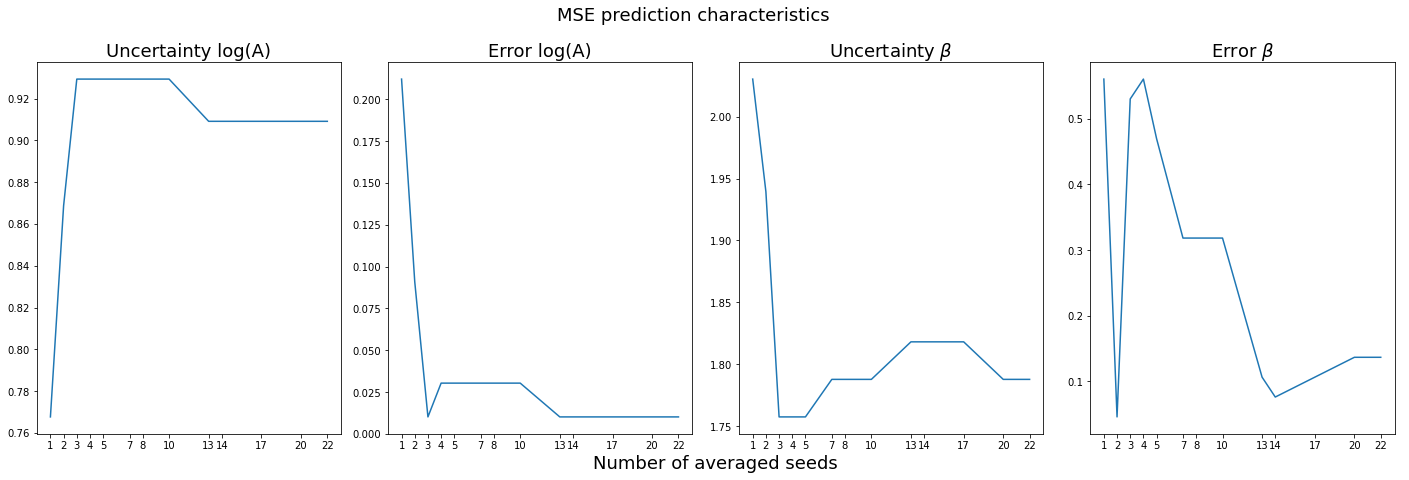

In [437]:
fig,ax=plt.subplots(1,4,figsize=(20,7))

ax[0].plot(Seeds_numbers,likelihood_LogAmps_scales)
ax[0].set_title('Uncertainty log(A)',fontsize=FS)


ax[1].plot(Seeds_numbers,np.abs(likelihood_LogAmps_errors))
ax[1].set_title('Error log(A)',fontsize=FS)


ax[2].plot(Seeds_numbers,likelihood_Beta_scales)
ax[2].set_title('Uncertainty 'r'$\beta$',fontsize=FS)

ax[3].plot(Seeds_numbers,np.abs(likelihood_Beta_errors))
ax[3].set_title('Error 'r'$\beta$',fontsize=FS)


for i in range(4):
    ax[i].set_xticks(Seeds_numbers)

fig.suptitle('MSE prediction characteristics',fontsize=FS)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Number of averaged seeds',fontsize=FS)

fig.tight_layout()
plt.show()

I would pick 14 phases

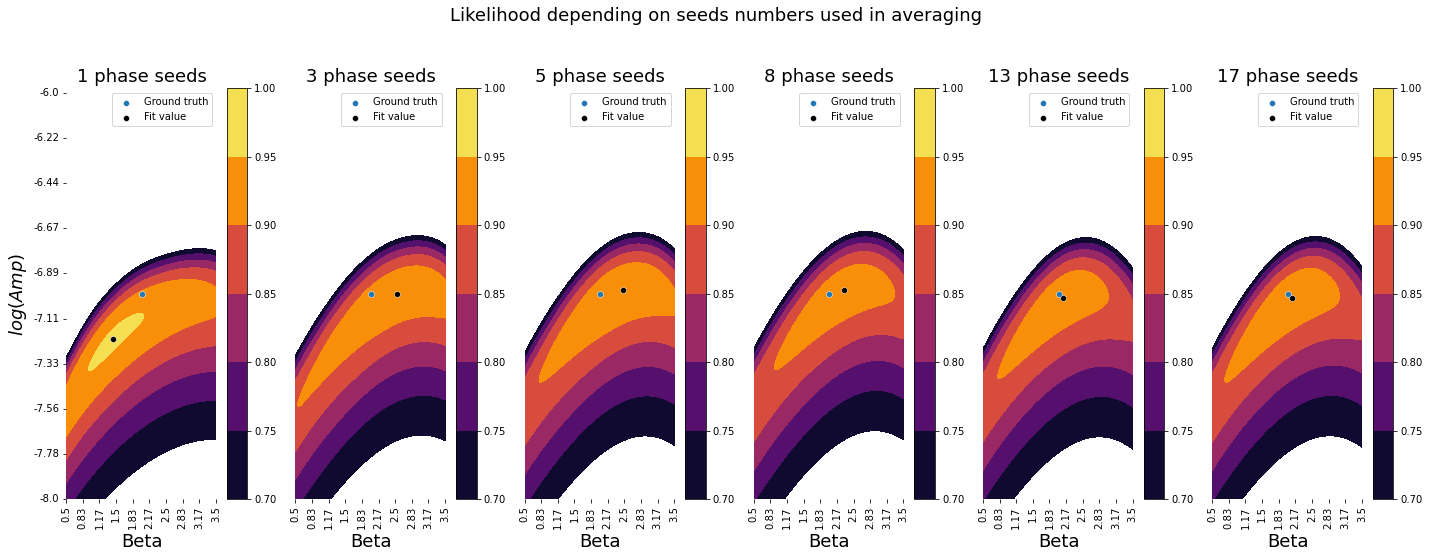

In [434]:
even_num=2*(len(loss_seeds_grid)//2)

fig,ax=plt.subplots(1,even_num//2,figsize=(20,7))

for i in range(0,even_num,2):
    i_fig=i//2
    loss_grid=loss_seeds_grid[i]
    likelihood=np.exp(-loss_grid/2)
    min_i,min_j=np.where(loss_grid==loss_grid.min())
    im=sns.heatmap(ax=ax[i_fig],data=likelihood,xticklabels=x_labels,yticklabels=yticklabels,alpha=0,cbar=False)
    
    ct=ax[i_fig].contourf(likelihood, levels=np.linspace(0.7,1,7), cmap='inferno')
    fig.colorbar(ct,ax=ax[i_fig])
    
    sns.scatterplot(ax=ax[i_fig],x=[50],y=[50],label='Ground truth')
    sns.scatterplot(ax=ax[i_fig],x=[min_j.item()],y=[min_i.item()],label='Fit value',color='black')
    
    ax[i_fig].legend()
    ax[i_fig].set_title('%d phase seeds'%(Seeds_numbers[i]),fontsize=FS)
    ax[i_fig].set_xlabel('Beta',fontsize=FS)
    ax[i_fig].set_ylabel(r'$log(Amp)$',fontsize=FS)
    ax[i_fig].invert_yaxis()
    if i_fig>0:
        ax[i_fig].axes.get_yaxis().set_visible(False)
    
    set_labels(im)
    
fig.tight_layout()
fig.suptitle('Likelihood depending on seeds numbers used in averaging',y=1.1,fontsize=FS)
plt.show()

# Fitting

In [81]:
def GRF_Loss_perfect_case_potential_std(GRF_params,GRF_seed,unperturbed_image,
             get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
             compute_radial_spectrum_pure,Spectra_Loss_pure):
    

  potential_std,Beta=GRF_params

  GRF_sample=get_jaxified_GRF_pure([-10.,Beta],GRF_seed)
  GRF=potential_std*GRF_sample/GRF_sample.std()

  simulated_image=simulate_perturbed_image_pure(GRF)

  resid=simulated_image-unperturbed_image
  resid_spectrum=compute_radial_spectrum_pure(resid)

  return Spectra_Loss_pure(resid_spectrum)


Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,compute_radial_spectrum_pure(data_image-unperturbed_data_image))

simulate_perturbed_image_pure_data=purify_function(simulate_perturbed_image,kwargs_data,perturbed_lens_image,x_coords,y_coords)

GRF_Loss_args=(GRF_seed,unperturbed_data_image,get_jaxified_GRF_pure,simulate_perturbed_image_pure_data,\
                compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_perfect_case_potential_std,*GRF_Loss_args)


In [86]:
def compute_func_on_grid(GRF_Amps_array,GRF_Betas_array,func,output_size):
    res=np.zeros((len(GRF_Amps_array),len(GRF_Betas_array),output_size))

    for i in range(len(GRF_Amps_array)):
        for j in range(len(GRF_Betas_array)):
            res[i,j]=func([GRF_Amps_array[i],GRF_Betas_array[j]])
            
    return res

In [90]:
GRF_realisation

DeviceArray([[ 3.25806937e-04, -1.39600163e-02, -2.37375768e-02, ...,
              -8.88541266e-03, -3.23081929e-03, -2.46492310e-03],
             [-7.24474457e-03, -1.77732719e-02, -2.79357125e-02, ...,
               1.05281659e-03, -4.40623246e-03, -2.26561027e-04],
             [-1.01756208e-02, -1.89674044e-02, -4.25634981e-02, ...,
              -1.32873739e-03, -6.52506532e-03,  5.27138495e-03],
             ...,
             [-9.65185178e-03, -6.77607686e-03, -1.10149004e-02, ...,
               1.62030230e-05, -7.61569564e-03, -1.78757703e-02],
             [-1.67147186e-03, -5.47283177e-03, -1.16820204e-02, ...,
               1.46123272e-02, -1.07998702e-02, -1.30477015e-02],
             [ 6.94097951e-03,  4.94321425e-03, -1.39605537e-02, ...,
               1.31260745e-02,  8.41794504e-03,  8.53962036e-03]],            dtype=float64)

In [91]:
GRF_realisation.std()

DeviceArray(0.01501326, dtype=float64)

In [92]:
GRF_Loss_pure([GRF_realisation.std(),GRF_beta])

DeviceArray(4.93198841e-15, dtype=float64)

In [85]:
GRF_sample=get_jaxified_GRF_pure([-10.,2.],GRF_seed)
0.01501326*GRF_sample/GRF_sample.std()

DeviceArray([[ 3.25807020e-04, -1.39600198e-02, -2.37375829e-02, ...,
              -8.88541494e-03, -3.23082012e-03, -2.46492373e-03],
             [-7.24474643e-03, -1.77732765e-02, -2.79357196e-02, ...,
               1.05281686e-03, -4.40623358e-03, -2.26561085e-04],
             [-1.01756234e-02, -1.89674092e-02, -4.25635089e-02, ...,
              -1.32873773e-03, -6.52506699e-03,  5.27138630e-03],
             ...,
             [-9.65185425e-03, -6.77607859e-03, -1.10149032e-02, ...,
               1.62030272e-05, -7.61569759e-03, -1.78757749e-02],
             [-1.67147229e-03, -5.47283317e-03, -1.16820234e-02, ...,
               1.46123309e-02, -1.07998730e-02, -1.30477049e-02],
             [ 6.94098129e-03,  4.94321551e-03, -1.39605573e-02, ...,
               1.31260778e-02,  8.41794720e-03,  8.53962255e-03]],            dtype=float64)

In [79]:
get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)

DeviceArray([[ 3.25806937e-04, -1.39600163e-02, -2.37375768e-02, ...,
              -8.88541266e-03, -3.23081929e-03, -2.46492310e-03],
             [-7.24474457e-03, -1.77732719e-02, -2.79357125e-02, ...,
               1.05281659e-03, -4.40623246e-03, -2.26561027e-04],
             [-1.01756208e-02, -1.89674044e-02, -4.25634981e-02, ...,
              -1.32873739e-03, -6.52506532e-03,  5.27138495e-03],
             ...,
             [-9.65185178e-03, -6.77607686e-03, -1.10149004e-02, ...,
               1.62030230e-05, -7.61569564e-03, -1.78757703e-02],
             [-1.67147186e-03, -5.47283177e-03, -1.16820204e-02, ...,
               1.46123272e-02, -1.07998702e-02, -1.30477015e-02],
             [ 6.94097951e-03,  4.94321425e-03, -1.39605537e-02, ...,
               1.31260745e-02,  8.41794504e-03,  8.53962036e-03]],            dtype=float64)

array([0.0001    , 0.00535789, 0.01061579, 0.01587368, 0.02113158,
       0.02638947, 0.03164737, 0.03690526, 0.04216316, 0.04742105,
       0.05267895, 0.05793684, 0.06319474, 0.06845263, 0.07371053,
       0.07896842, 0.08422632, 0.08948421, 0.09474211, 0.1       ])

In [106]:
GRF_potential_stds_array_wide=np.linspace(1e-4,0.1,20)
GRF_Betas_array_wide=np.linspace(1,8,20)

In [107]:
perfect_loss_wide_grid=compute_func_on_grid(GRF_potential_stds_array_wide,GRF_Betas_array_wide,GRF_Loss_pure,1)[:,:,0]

<AxesSubplot:>

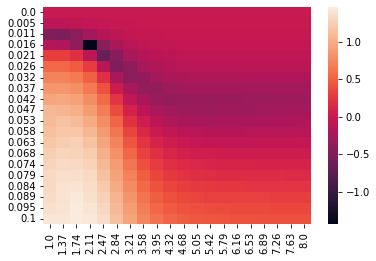

In [108]:
sns.heatmap(np.log10(perfect_loss_wide_grid),xticklabels=np.round(GRF_Betas_array_wide,2),yticklabels=np.round(GRF_potential_stds_array_wide,3))

In [101]:
np.where(perfect_loss_wide_grid==perfect_loss_wide_grid.min())

(array([3]), array([19]))

In [102]:
perfect_loss_wide_grid[3,19]

0.12346724737621824

In [103]:
GRF_Betas_array_wide[19]

2.0

In [104]:
GRF_potential_stds_array_wide[3]

0.015873684210526314